# FIFA World Rankings Analysis with Python and R
## Part 2 - National Team Value Analysis
Author: [Kenneth Leung](https://github.com/kennethleungty)  
Data Source: https://www.transfermarkt.co.uk/wettbewerbe/fifa/wettbewerbe
___

#### 1. Initial setup

In [1]:
# Import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from statsmodels.api import OLS
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [2]:
# Import datasets
df_national_team_value = pd.read_csv('./data/fifa_rankings_national_teams_value_20210807.csv', 
                                     encoding = "ISO-8859-1", 
                                     engine='python')
df_population = pd.read_excel('./data/country_population_2020.xlsx')

# Review dataset of top 150 ranked teams
df_national_team_value

,rank,nation,squad_size,average_age,total_value_pounds,confederation,points
0,1,Belgium,26,29.2,£601.56m,UEFA,1783
1,2,France,26,28.0,£925.20m,UEFA,1757
2,3,Brazil,25,27.5,£826.20m,CONMEBOL,1743
3,4,England,26,25.4,£1.16bn,UEFA,1687
4,5,Portugal,26,27.9,£747.45m,UEFA,1666
...,...,...,...,...,...,...,...
145,147,Nicaragua,24,27.4,£1.87m,CONCACAF,1061
146,148,Kuwait,23,26.8,£6.55m,AFC,1056
147,149,Afghanistan,23,26.8,£2.01m,AFC,1052
148,150,Botswana,21,27.1,£1.13m,CAF,1052


In [3]:
# Convert all values to be based on million dolloar pounds
def convert_to_million(x):
    if 'bn' in x:
        billion_value = float(re.sub("[^0-9.]", "", x))
        million_value = billion_value * 1000 
    elif 'Th.' in x:
        thousand_value = float(re.sub("[^0-9.]", "", x))
        million_value = thousand_value / 1000
    else:
        million_value = float(re.sub("[^0-9.]", "", x))
    return million_value

# Process total team value column
df_national_team_value['total_value_pounds'] = df_national_team_value['total_value_pounds'].apply(lambda x : x.replace('£', ''))
df_national_team_value['total_value_pounds'] = df_national_team_value['total_value_pounds'].apply(lambda x : convert_to_million(x))
df_national_team_value.rename(columns={"total_value_pounds": "team_value_mil_pounds"}, inplace=True)

# Create column to calculate average value per player in national team
# Using average value (instead of total value) because different teams have different squad sizes
df_national_team_value['avg_value_mil_pounds'] = df_national_team_value['team_value_mil_pounds'] / \
                                                 df_national_team_value['squad_size']

# Rearrange columns
df_national_team_value = df_national_team_value[['nation','squad_size','average_age',
                                                 'team_value_mil_pounds', 'avg_value_mil_pounds',
                                                 'confederation', 'rank','points']]
df_national_team_value.head(10)

,nation,squad_size,average_age,team_value_mil_pounds,avg_value_mil_pounds,confederation,rank,points
0,Belgium,26,29.2,601.56,23.136923,UEFA,1,1783
1,France,26,28.0,925.20,35.584615,UEFA,2,1757
2,Brazil,25,27.5,826.20,33.048000,CONMEBOL,3,1743
3,England,26,25.4,1160.00,44.615385,UEFA,4,1687
4,Portugal,26,27.9,747.45,28.748077,UEFA,5,1666
5,Spain,24,26.7,839.70,34.987500,UEFA,6,1648
6,Italy,26,27.9,695.70,26.757692,UEFA,7,1642
7,Argentina,28,27.7,598.95,21.391071,CONMEBOL,8,1642
8,Uruguay,26,27.5,340.56,13.098462,CONMEBOL,9,1639
9,Denmark,26,27.9,297.63,11.447308,UEFA,10,1632


#### 2. Include population data

In [4]:
# Merge population data with country
df_population.head()

,Country,Population,Yearly Change,Net Change,Density (P/KmÂ²),Land Area (KmÂ²),Migrants (net),Fert. Rate,Med. Age,Urban Pop %,World Share
0,China,1440297825,0.0039,5540090.0,153.0,9388211.0,-348399.0,1.7,38,0.61,0.1847
1,India,1382345085,0.0099,13586631.0,464.0,2973190.0,-532687.0,2.2,28,0.35,0.1770
2,United States,331341050,0.0059,1937734.0,36.0,9147420.0,954806.0,1.8,38,0.83,0.0425
3,Indonesia,274021604,0.0107,2898047.0,151.0,1811570.0,-98955.0,2.3,30,0.56,0.0351
4,Pakistan,221612785,0.0200,4327022.0,287.0,770880.0,-233379.0,3.6,23,0.35,0.0283


In [5]:
# Create subset of population df
df_population_sm = df_population[['Country', 'Population', 'Urban Pop %']]

# Merge dataframes of national team value and population
df_national_merged = df_national_team_value.merge(df_population_sm, left_on='nation',
                                                 right_on='Country', how='left')

# Standardize all column names
df_national_merged.rename(columns={"Country": "country", 
                                   "Population": "population",
                                   "Urban Pop %": "urban_pop_percent"}, 
                          inplace=True)

# Add log columns
df_national_merged['log_population'] = np.log(df_national_merged['population'])
df_national_merged['log_team_value'] = np.log(df_national_merged['team_value_mil_pounds'])
df_national_merged['log_avg_value'] = np.log(df_national_merged['avg_value_mil_pounds'])
df_national_merged.head(10)

,nation,squad_size,average_age,team_value_mil_pounds,avg_value_mil_pounds,confederation,rank,points,country,population,urban_pop_percent,log_population,log_team_value,log_avg_value
0,Belgium,26,29.2,601.56,23.136923,UEFA,1,1783,Belgium,11598451,0.98,16.266382,6.399526,3.141430
1,France,26,28.0,925.20,35.584615,UEFA,2,1757,France,65298930,0.82,17.994486,6.830010,3.571913
2,Brazil,25,27.5,826.20,33.048000,CONMEBOL,3,1743,Brazil,212821986,0.88,19.175967,6.716837,3.497961
3,England,26,25.4,1160.00,44.615385,UEFA,4,1687,England,56286961,0.83,17.845973,7.056175,3.798079
4,Portugal,26,27.9,747.45,28.748077,UEFA,5,1666,Portugal,10191409,0.66,16.137056,6.616667,3.358571
5,Spain,24,26.7,839.70,34.987500,UEFA,6,1648,Spain,46757980,0.8,17.660495,6.733045,3.554991
6,Italy,26,27.9,695.70,26.757692,UEFA,7,1642,Italy,60446035,0.69,17.917262,6.544919,3.286822
7,Argentina,28,27.7,598.95,21.391071,CONMEBOL,8,1642,Argentina,45267449,0.93,17.628099,6.395178,3.062974
8,Uruguay,26,27.5,340.56,13.098462,CONMEBOL,9,1639,Uruguay,3475842,0.96,15.061347,5.830591,2.572495
9,Denmark,26,27.9,297.63,11.447308,UEFA,10,1632,Denmark,5795780,0.88,15.572641,5.695851,2.437755


#### Analysis 1 - National Team Value and FIFA Points

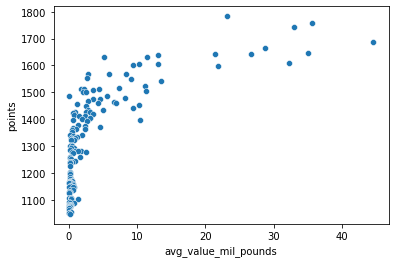

In [6]:
sns.scatterplot(data=df_national_merged, x="avg_value_mil_pounds", y="points");

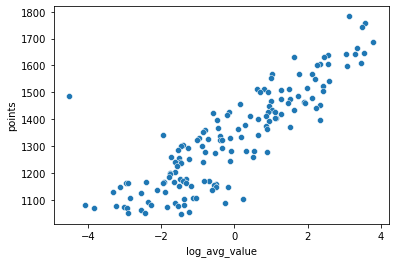

In [7]:
# Displaying effect of applying log transformation on average national team value
sns.scatterplot(data=df_national_merged, x="log_avg_value", y="points");

#### Analysis 2 - Population and FIFA Points

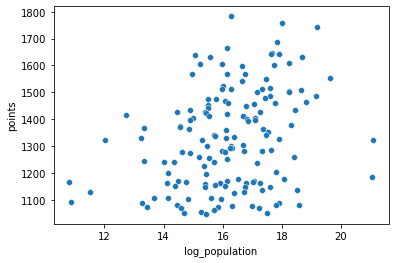

In [8]:
sns.scatterplot(data=df_national_merged, x="log_population", y="points");

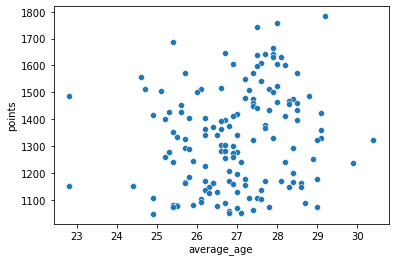

In [9]:
sns.scatterplot(data=df_national_merged, x="average_age", y="points");

#### Analysis 3 - Regression model

In [10]:
df_national_merged.head(15)

,nation,squad_size,average_age,team_value_mil_pounds,avg_value_mil_pounds,confederation,rank,points,country,population,urban_pop_percent,log_population,log_team_value,log_avg_value
0,Belgium,26,29.2,601.56,23.136923,UEFA,1,1783,Belgium,11598451,0.98,16.266382,6.399526,3.141430
1,France,26,28.0,925.20,35.584615,UEFA,2,1757,France,65298930,0.82,17.994486,6.830010,3.571913
2,Brazil,25,27.5,826.20,33.048000,CONMEBOL,3,1743,Brazil,212821986,0.88,19.175967,6.716837,3.497961
3,England,26,25.4,1160.00,44.615385,UEFA,4,1687,England,56286961,0.83,17.845973,7.056175,3.798079
4,Portugal,26,27.9,747.45,28.748077,UEFA,5,1666,Portugal,10191409,0.66,16.137056,6.616667,3.358571
5,Spain,24,26.7,839.70,34.987500,UEFA,6,1648,Spain,46757980,0.8,17.660495,6.733045,3.554991
6,Italy,26,27.9,695.70,26.757692,UEFA,7,1642,Italy,60446035,0.69,17.917262,6.544919,3.286822
7,Argentina,28,27.7,598.95,21.391071,CONMEBOL,8,1642,Argentina,45267449,0.93,17.628099,6.395178,3.062974
8,Uruguay,26,27.5,340.56,13.098462,CONMEBOL,9,1639,Uruguay,3475842,0.96,15.061347,5.830591,2.572495
9,Denmark,26,27.9,297.63,11.447308,UEFA,10,1632,Denmark,5795780,0.88,15.572641,5.695851,2.437755


In [11]:
# Convert urban pop percent column dtype from object to numeric
df_national_merged['urban_pop_percent'] = pd.to_numeric(df_national_merged['urban_pop_percent'], errors='coerce')

# Drop rows with any NaN
df_national_merged = df_national_merged.dropna()

In [13]:
# Setup dataset for linear regression
X_cols = [
#           'average_age', 
#           'log_population', 
          'log_avg_value', # Selecting only 1 variable for simple monovariate linear regression
#           'avg_value_mil_pounds',
#           'urban_pop_percent'
         ]

# Separate the independent and target variables
df_X = df_national_merged[X_cols]
df_y = df_national_merged['points']

In [14]:
# Linear regression with sklearn
lin_reg = LinearRegression()
lin_reg.fit(df_X, df_y)

# Get metrics
print(f'Coefficients: {lin_reg.coef_}')
print(f'Intercept: {lin_reg.intercept_}')
print(f'R^2 score: {lin_reg.score(df_X, df_y)}')

adjusted_r2 = 1 - (1-lin_reg.score(df_X, df_y))*(len(df_y)-1)/(len(df_y)-df_X.shape[1]-1)
print(f'Adjusted R^2 score: {adjusted_r2}')

Coefficients: [84.0145744]
Intercept: 1340.6809836886548
R^2 score: 0.746271867541619
Adjusted R^2 score: 0.7445098666217691


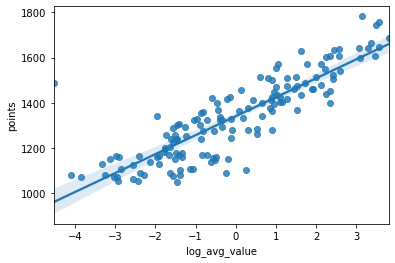

In [18]:
# Visualize the linear regression
sns.regplot(x="log_avg_value", y="points", data=df_national_merged);